In [5]:
# Imports

%matplotlib widget

import ipywidgets as widgets
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift
import scipy.signal as sc
import scipy.io.wavfile as sc_wav
import csv 
import pandas as pd


In [22]:

#This function takes an input frequency and outputs its nearest pitch in a
#given table of pitches

def compareToPitches(pitch, pitchtable):

    #In case pitchtable is not sorted in ascending order
    #sortedpitchtable = sort(pitchtable) 

    #Pre-allocates memory for array
    #midpitchtable = zeros(1,length(sortedpitchtable)-1)

    #Boolean that indicates if the closest pitch to the input frequency has been found 
    found = 0

    #Generates a table of "average" pitches from pitchtable to make comparison easier.
    #log2(0.5) is used instead of 0.5 in order to account for logarithmic 
    #sound perception.
    #for i = 1:(length(sortedpitchtable)-1)
    #   midpitchtable(i) = (sortedpitchtable[i+1] - sortedpitchtable(i))*log2(0.5) + sortedpitchtable(i)
    #end

    #If input frequency is lower than the lowest pitch in the table, output
    #the lowest pitch in the table and set found to true.
    if pitch <= pitchtable[0]:
        exactpitch = pitchtable[0]
        found = 1


    #If exactpitch has not been found yet, and if input frequency is higher than the highest pitch in the table, output
    #the highest pitch in the table and set found to true.
    if found==0:
        if pitch > pitchtable[len(pitchtable)-1]:
            exactpitch = pitchtable[len(pitchtable)-1]
            found = 1
        


    #If exactpitch has not been found yet, compare it to all values in the
    #midpitchtable and output the corresponding pitch in pitchtable. 
    i = 1
    while found==0:
        if pitch > pitchtable[i] and pitch <= pitchtable[i+1]:
            exactpitch = pitchtable[i+1]
            found=1
        i = i+1

    return exactpitch




In [20]:
def auto_corr(x,fm):

    T=1/fm 
    #por que no me andan los commits lpm
    pmin=50
    pmax=200

    Tmin=1/pmax
    Tmax=1/pmin

    nmin=int(math.floor(Tmin/T))
    nmax=int(math.ceil(Tmax/T))

    x_cor=np.correlate(x,x,mode='full')
    x_cor=x_cor[len(x):len(x_cor)]

    i=np.argmax(x_cor[nmin:nmax])

    npitch=i+nmin
    Tpitch=npitch*T

    Fpitch=1/Tpitch

    return Fpitch



4153
4153


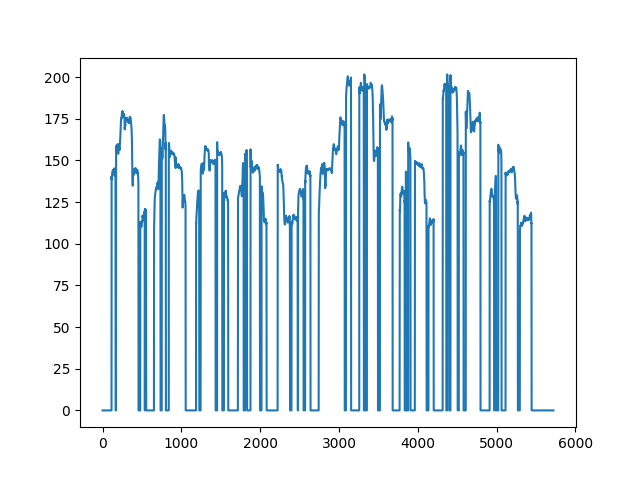

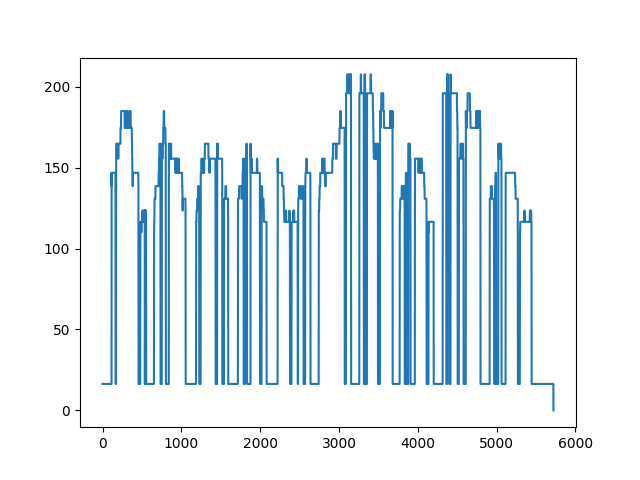

In [25]:
rate, signal = sc_wav.read('dataset_proyecto/vocadito_1.wav')

ref_aux=pd.read_csv('dataset_proyecto/vocadito_1_f0.csv',names=['f0','t'])

# list with each item representing a column
ref = []
for col in ref_aux:
    # convert pandas series to list
    col_ref = ref_aux[col].tolist()
    # append column list to ls
    ref.append(col_ref)
# print the created list

ref_f0=ref[1]
ref_t=ref[0]


tvent = 0.032
tstep = tvent*0.25


nvent = int(tvent*rate)
nstep = int(tstep*rate)

nframes=len(ref[0])
nframes=int((len(signal)-nvent-nvent/2-nstep)/nstep)

cant_vent = int((len(signal)/nvent))
vent = np.hamming(nvent)

ini=nvent//2
p_corr = np.zeros(nframes)
print(nframes)
print(len(p_corr))
for i in range(nframes):
    if ref_f0[i]>0:
        p_corr[i] = auto_corr(signal[ini:ini + nvent]*vent,rate)
    
    ini = ini + nstep


treshold = 200
for i in range(nframes-1):
    if  abs(p_corr[i+1]-p_corr[i]) or abs(p_corr[i-1]-p_corr[i]) >=treshold:
        if p_corr[i-1]!=0 and p_corr[i+1]!=0:
            p_corr[i]=p_corr[i-1]/2 + p_corr[i+1]/2
        else:
            p_corr[i]=0


#plt.close('all')
#plt.plot(p_corr)
#plt.show()

plt.figure()
plt.plot(ref_f0)
plt.show()

pitch_table=[16.352,17.324,18.354,19.445,20.602,21.827,23.125,24.500,25.957,27.500,29.135,30.868,32.703,34.648,36.708,38.891,41.203,43.654,46.249,48.999,51.913,55.000,58.270,61.735,65.406,69.296,73.416,77.782,82.407,87.307,92.499,97.999,103.830,110.000,116.540,123.470,130.800,138.590,146.830,155.560,164.810,174.610,185.000,196.000,207.650,220.000,233.080,246.940,261.630,277.180,293.660,311.130,329.630,349.230,369.990,392.000,415.300,440.000,466.160,493.880,523.250,554.370,587.330,622.250,659.260,698.460,739.990,783.990,830.610,880.000,932.330,987.770,1046.500,1108.700,1174.700,1244.500,1318.500,1396.900,1480.000,1568.000,1661.200,1760.000,1864.700,1975.500,2093.000,2217.500,2349.300,2489.000,2637.000,2793.800,2960.000,3136.000,3322.400,3520.000,3729.300,3951.100,4186.000,4434.900,4698.600,4978.000,5274.000,5587.700,5919.900,6271.900,6644.900,7040.000,7458.600,7902.100,8372.000,8869.800,9397.300,9956.100,10548.100,11175.300,11839.800,12543.900,13289.800,14080.000,14917.200,15804.300,16744.000,17739.700,18794.500,19912.100,21096.200,22350.600]
corrected_pitch=np.zeros(len(ref_f0))
for i in range(len(ref_f0)-1):
    corrected_pitch[i]=compareToPitches(ref_f0[i], pitch_table)

plt.figure()
plt.plot(corrected_pitch)
plt.show()
